# Social Network Analysis - Class 6 - Centrality

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import networkx as nx

In [77]:
advice_df = pd.read_csv('Data/Lazega-Advice-Net.csv', skiprows=1, names=list(np.arange(1, 72)))
advice_df.index = list(np.arange(1, 72))

friend_df = pd.read_csv('Data/Lazega-Friends.csv', skiprows=1, names=list(np.arange(1, 72)))
friend_df.index = list(np.arange(1, 72))

In [78]:
# Create undirected and directed graphs
undir_g_advice = nx.from_pandas_adjacency(advice_df)
dir_g_advice = nx.from_pandas_adjacency(advice_df, create_using=nx.DiGraph())

undir_g_friend = nx.from_pandas_adjacency(friend_df)
dir_g_friend = nx.from_pandas_adjacency(friend_df, create_using=nx.DiGraph())

In [80]:
# slide 16
print("Advice undirected density: ", round(nx.density(undir_g_advice), 3))
print("Advice directed density: ", round(nx.density(dir_g_advice), 3))

Advice undirected density:  0.225
Advice directed density:  0.123


In [21]:
# slide 18
print("Friend undirected density: ", round(nx.density(undir_g_friend), 3))
print("Friend directed density: ", round(nx.density(dir_g_friend), 3))

Friend undirected density:  0.292
Friend directed density:  0.172


In [34]:
lazega_attr = pd.read_csv('Data/Lazega-Atts.csv')

# attach attributes to vertices
lazega_attr = lazega_attr.set_index('ID', drop=False)
attr_dict = lazega_attr.to_dict('index')
nx.set_node_attributes(undir_g_friend, attr_dict)

In [30]:
# slide 22
# calculate density for partner and associate graphs
partner_ids = lazega_attr[lazega_attr.status==1].index
assoc_ids = lazega_attr[lazega_attr.status==2].index 

partner_df = friend_df.loc[partner_ids, partner_ids]
assoc_df = friend_df.loc[assoc_ids, assoc_ids]

partner_g = nx.from_pandas_adjacency(partner_df) 
assoc_g = nx.from_pandas_adjacency(assoc_df)

print("partner density = ", round(nx.density(partner_g), 3))
print("associate density = ", round(nx.density(assoc_g), 3))

partner density =  0.354
associate density =  0.267


## Centrality measures

In [2]:
# slide 34

# create Advice network graph
import igraph as ig

test = pd.read_csv('Data/Lazega-Advice-Net.csv', skiprows=1, names=list(np.arange(1, 72)))
test.index = list(np.arange(1, 72))

testmg = ig.Graph.Adjacency((test.values>0).tolist())
testmg.vs['ID'] = test.index

In [3]:
# slide 35
# attach the attributes to the vertices

lazega_attr = pd.read_csv('Data/Lazega-Atts.csv')

for c in lazega_attr.columns:
    testmg.vs[c] = lazega_attr.loc[lazega_attr.ID==testmg.vs['ID'], c]

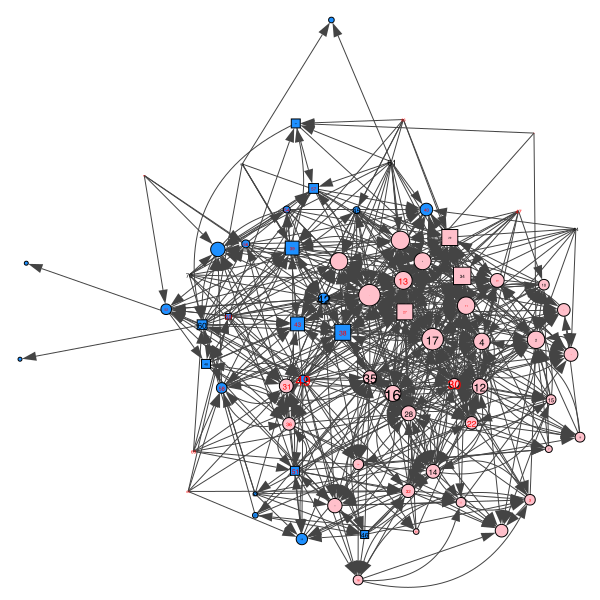

In [43]:
# slide 36
# plot the graph

layout_kk = testmg.layout_kamada_kawai()

gender_shape = {1: "circle", 2: "rectangle"}
status_color = {1: "pink", 2: "dodgerblue"}
practice_color = {1: "red", 2: "black"}
testmg.vs['size'] = 4*np.sqrt(testmg.indegree())
testmg.vs['label_cex'] = 15*np.array(testmg.outdegree())/max(testmg.outdegree())

ig.plot(testmg, layout=layout_kk, 
        vertex_shape = [gender_shape[gender] for gender in testmg.vs['gender']],
        vertex_color = [status_color[status] for status in testmg.vs['status']], 
        vertex_label = testmg.vs['ID'],
        vertex_label_color = [practice_color[practice] for practice in testmg.vs['practice']],
        vertex_size = testmg.vs['size'],
        vertex_label_size = testmg.vs['label_cex'])


Note that I initially encountered an attribute error: "bytes' object has no attribute 'encode'" when executing the above command. There is a fix for this error but there is no new release that incorporates this fix as of the time of this writing. So if you encounter this error, you will have to update the source code manually following this patch: https://github.com/igraph/python-igraph/commit/8864b46849b031a3013764d03e167222963c0f5d

(See related GitHub issue for more info: https://github.com/igraph/python-igraph/issues/88)

## Calculating "centrality"

In [69]:
# slide 99
d_in = testmg.indegree()
d_out = testmg.outdegree()
degree = testmg.degree()
btwn = testmg.betweenness(directed=False)
close = testmg.closeness(normalized=False)
eigen = testmg.evcent(directed=False)

The Bonacich Power Centrality Score function is not available in the Python implementation of `igraph` as of the time of this writing

In [58]:
dd = lazega_attr.copy()
dd = dd.set_index("ID", drop=False)

In [75]:
# slide 100 - 101
dd['d_in'] = testmg.indegree()
dd['d_out'] = testmg.outdegree()
dd['degree'] = testmg.degree()
dd['btwn'] = testmg.betweenness(directed=False)
dd['close'] = testmg.closeness(normalized=False)
dd['eigen'] = testmg.evcent(directed=False)

dd.head()

,ID,status,gender,office,seniority,age,practice,lawschool,d_in,d_out,degree,btwn,close,eigen
0,1,1,1,1,31,64,1,1,12,3,15,11.809535,0.007519,0.339216
1,2,1,1,1,32,62,2,1,19,7,26,53.277764,0.008333,0.537202
2,3,1,1,2,13,67,1,1,7,7,14,8.600505,0.006944,0.276623
3,4,1,1,1,31,59,2,3,17,17,34,55.105151,0.008772,0.729378
4,5,1,1,2,31,59,1,2,6,4,10,9.009522,0.007143,0.131911


In [74]:
# slide 102
cb2 = dd[['d_in', 'd_out', 'degree', 'btwn', 'close', 'eigen']].copy()

cb2.corr()

,d_in,d_out,degree,btwn,close,eigen
d_in,1.000000,0.097809,0.764550,0.440272,0.713003,0.786003
d_out,0.097809,1.000000,0.716254,0.719363,0.646236,0.635160
degree,0.764550,0.716254,1.000000,0.774630,0.918506,0.962521
btwn,0.440272,0.719363,0.774630,1.000000,0.696240,0.632369
close,0.713003,0.646236,0.918506,0.696240,1.000000,0.868934
eigen,0.786003,0.635160,0.962521,0.632369,0.868934,1.000000


In [76]:
# save "dd" file to be used in class 7
dd.to_csv('lazega_graph_data.csv', index_label=False)